## Import libraries

In [1]:
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load data

In [2]:
df = pd.read_csv('seiyuu.csv')
anime_data = json.loads(open('anime-offline-database.json').read())

In [3]:
df.head()

,anime,type,character,anime_id,name,group
0,Ousama Game The Animation,Supporting,"Iwamura, Ria",36027,Pile,muse
1,KochinPa! Dainiki,Main,Aira,34503,Pile,muse
2,Love Live! x Watering KissMint Collaboration CM,Main,"Nishikino, Maki",32730,Pile,muse
3,KochinPa!,Main,Aira,32400,Pile,muse
4,Love Live! The School Idol Movie,Main,"Nishikino, Maki",24997,Pile,muse


## Preprocess anime data

### Only keep MAL sources

In [4]:
for anime in tqdm(anime_data['data']):
    mal_url = next((x for x in anime['sources'] if 'myanimelist.net' in x), None)
    anime['year'] = anime['animeSeason']['year']
    anime['season'] = anime['animeSeason']['season']
    del anime['animeSeason']
    del anime['sources']
    del anime['picture']
    del anime['thumbnail']
    del anime['relations']
    
    if not mal_url:
        anime['mal_id'] = np.nan
    else:
        anime['mal_id'] = int(re.search('/anime/(\d+)', mal_url).group(1))

100%|█████████████████████████████████| 33210/33210 [00:00<00:00, 296056.56it/s]


In [5]:
anime_df = pd.DataFrame(anime_data['data'])
anime_df

,title,type,episodes,status,synonyms,tags,year,season,mal_id
0,!NVADE SHOW!,SPECIAL,1,FINISHED,[],"[band, music]",2020.0,UNDEFINED,45106.0
1,"""0""",SPECIAL,1,FINISHED,"[""Zero"", Chiaki Kuriyama - 0, Chiaki Kuriyama ...","[female protagonist, music]",2013.0,SUMMER,20707.0
2,"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokub...",MOVIE,1,FINISHED,"[""いそっぷ""のおはなしより 牛とかえる, ""いそっぷ""のおはなしより 牛とかえる, よくば...","[fantasy, kids]",1970.0,WINTER,25627.0
3,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",OVA,1,FINISHED,"[""文学少女""今日のおやつ ~はつ恋~, Book Girl OVA, Bungaku Sh...","[asia, based on a light novel, comedy, drama, ...",2009.0,FALL,7669.0
4,"""Bungaku Shoujo"" Memoire",OVA,3,FINISHED,"[""文学少女"" メモワール, Book Girl Memories, Book Girl: ...","[angst, asia, based on a light novel, classic ...",2010.0,SPRING,8481.0
...,...,...,...,...,...,...,...,...,...
33205,フルアニ 初回限定版,OVA,1,FINISHED,[Fullani],[adventure],2006.0,UNDEFINED,46124.0
33206,仙尊奶爸当赘婿,TV,0,ONGOING,"[The Love Story of My Immortal Dad, Xianzun's ...","[adventure, comedy, fantasy, martial arts, rom...",2020.0,UNDEFINED,50194.0
33207,別冊: 仮面ライダーセイバー 短編活動寓画集,ONA,0,ONGOING,[Extra Issue: Kamen Rider Saber Short Animated...,"[adventure, comedy, fantasy, kids, slice of life]",2021.0,UNDEFINED,48721.0
33208,剑域风云,SPECIAL,0,ONGOING,[The Legend of Sword Domain],"[action, adventure]",NaN,UNDEFINED,50501.0


## For each seiyuu, draw plot of num of main/support/staff roles

### Preprocess data
Do not remove `Staff` rows.

In [6]:
df1 = df[df.type != 'Staff'].drop_duplicates(subset=['name', 'character'])
df1 = pd.concat([df1, df[df.type == 'Staff']])

### Calculate summary data

For each seiyuu: calculate num of main/support/staff roles.

In [7]:
df1 = df1[['name', 'type', 'anime']].groupby(['name', 'type']).count()
df1

anime
name         type             
Aida, Rikako Main            4
             Staff           4
             Supporting      9
Furihata, Ai Main            4
             Staff           2
...                        ...
Uchida, Aya  Staff          21
             Supporting     34
Yano, Hinaki Main            4
             Staff           1
             Supporting      1

[87 rows x 1 columns]

In [8]:
df1 = df1.unstack()
df1.columns = df1.columns.droplevel()
df1 = df1[['Main', 'Supporting', 'Staff']]
df1

type,Main,Supporting,Staff
name,,,
"Aida, Rikako",4.0,9.0,4.0
"Furihata, Ai",4.0,1.0,2.0
"Iida, Riho",5.0,11.0,14.0
"Inami, Anju",4.0,1.0,1.0
"Kitou, Akari",28.0,20.0,13.0
"Kobayashi, Aika",1.0,2.0,8.0
"Komiya, Arisa",1.0,1.0,1.0
"Kubo, Yurika",20.0,43.0,16.0
"Kubota, Miyu",4.0,10.0,3.0


### Draw plot

In [9]:
# plt.style.use('seaborn')
plt.rcParams['font.size'] = '12'

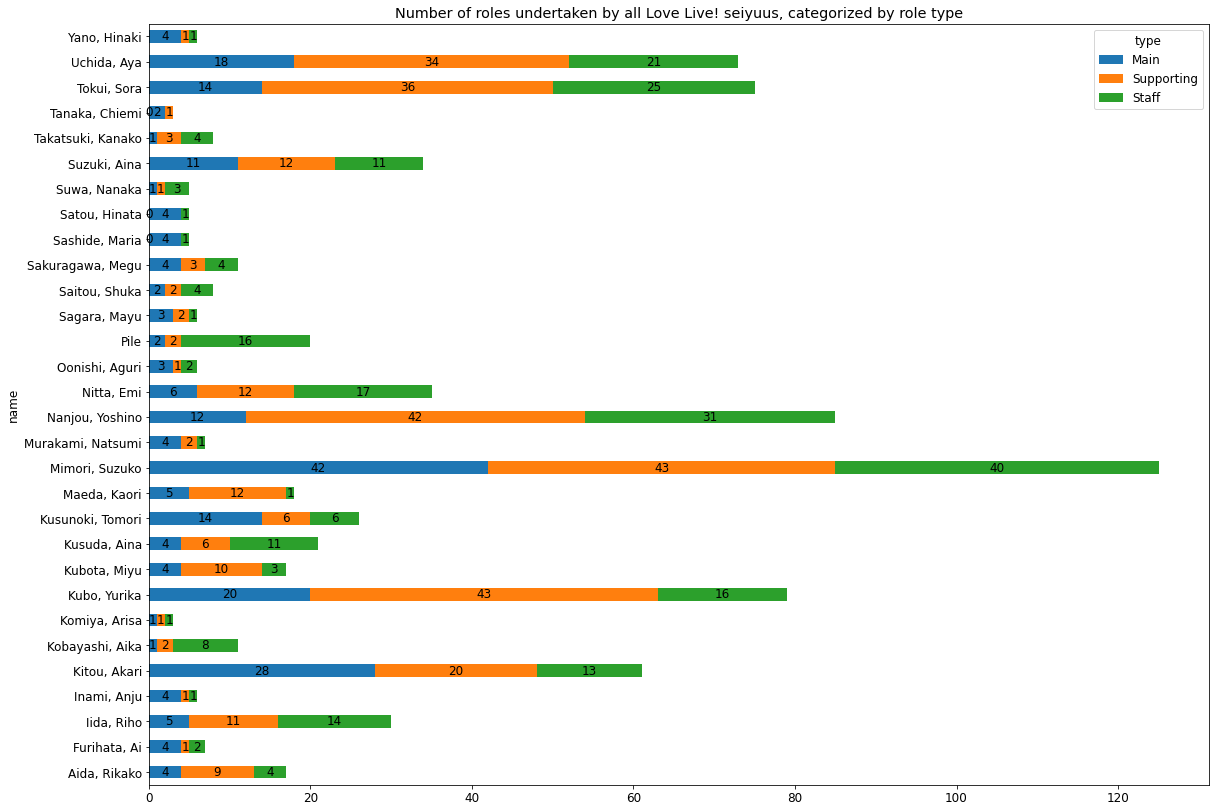

In [10]:
df1.plot(
    kind='barh',
    figsize=(19, 14),
    stacked=True,
    title='Number of roles undertaken by all Love Live! seiyuus, categorized by role type'
)
ax = plt.gca()
for p in ax.containers:
    ax.bar_label(p, label_type='center')
fig = plt.gcf()
fig.savefig('fig1.png', transparent=False, facecolor='white', dpi=300)

## For each seiyuu, draw line plot for number of anime participated per year

In [11]:
# SQL LEFT OUTER JOIN
joined_df = df.merge(anime_df, left_on='anime_id', right_on='mal_id', how='inner')

In [12]:
# Remove errorneous data (MAL's fault)
joined_df = joined_df[~(joined_df.year < 2000)]

In [13]:
df2 = joined_df.groupby(['name', 'year'])['mal_id'].count().to_frame()
df2 = df2.unstack().fillna(0)
# .plot(kind='line') requires columns to be classes
df2 = df2.T
df2.index = df2.index.droplevel()

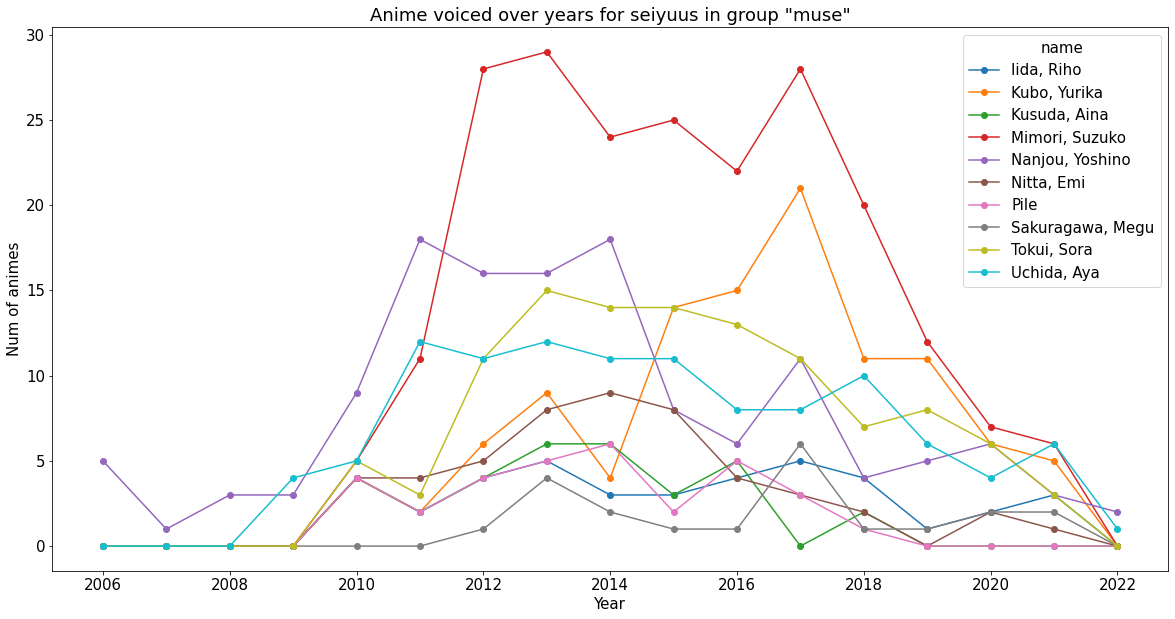

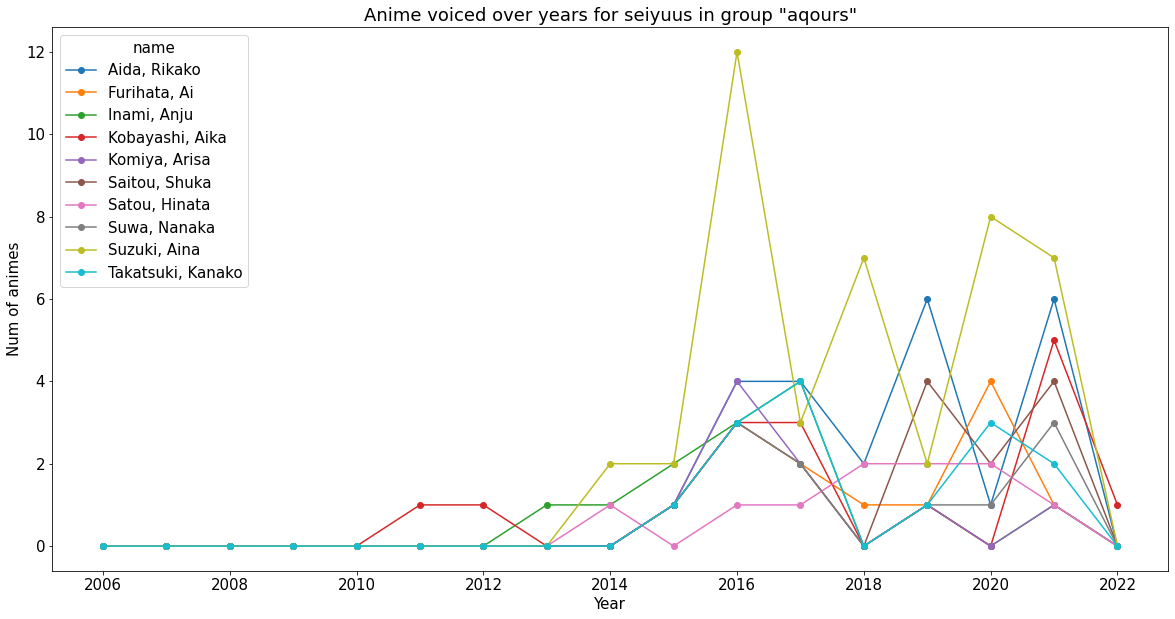

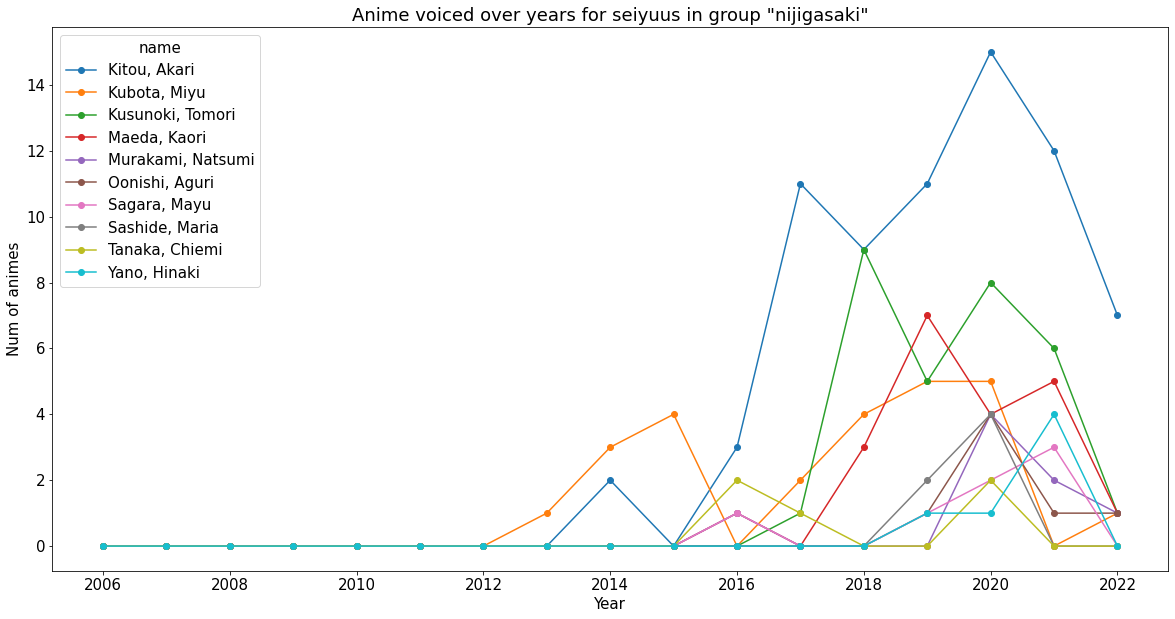

In [14]:
# Draw 3 plots for muse, aqours and nijigasaki
plt.rcParams['font.size'] = '15'
df2_g = df2.T.reset_index().merge(df, left_on='name', right_on='name')
df2_g = df2_g.set_index('name')
df2_g.drop(['anime', 'type', 'character', 'anime_id'], axis=1, inplace=True)
df2_g.drop_duplicates(inplace=True)

for group in df.group.unique():
    tmp_df = df2_g[df2_g.group == group].drop('group', axis=1)
    seiyuus = tmp_df.index.unique()
    colors = sns.color_palette('husl', n_colors=len(seiyuus))  

    tmp_df.T.plot(
        kind='line',
        figsize=(20, 10),
        marker='o',
        title=f'Anime voiced over years for seiyuus in group "{group}"',
        xlabel='Year',
        ylabel='Num of animes'
    )
    plt.gca().set_prop_cycle('color', colors)
    plt.gcf().savefig(f'overyears-{group}.png', transparent=False, facecolor='white', dpi=300)
    